# Detecting Gaze in using the "Eye Tracking for Everyone" Neural Network

This will go through the process of extracting the features from an image that are needed for the neural network, testing the input, and displaying the output.

## Extracting the Inputs from an Image using OpenCV

The neural network requires as inputs:
* an image of the left eye, (224x224)
* an image of the right eye (224x224)
* an image of the fafce (224x224)
* a 625 array representing where in a 25x25 grid the face is

Here we will use OpenCV to extract this from a single image.  Much of this code is based on the instruction at 
https://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# filter out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
cascades_path = '/usr/share/opencv/haarcascades/'
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

In [3]:
import time

def current_time():
    return int(round(time.time() * 1000))

def extract_face_features(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]
    face_image = np.copy(img[y:y+h, x:x+w])
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    eye_images = []
    for (ex,ey,ew,eh) in eyes:
        eye_images.append(np.copy(img[y+ey:y+ey+eh,x+ex:x+ex+ew]))
                
    roi_color = img[y:y+h, x:x+w]
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
    
    return face_image, eye_images

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(full_img_path):
    img = cv2.imread(full_img_path)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    faces = []
    face_features = []
    for [x,y,w,h] in face_detections:
        face = [x, y, w, h]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        face_image, eye_images = extract_face_features(face, img, gray)
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)
        
        faces.append(face)
        face_features.append([face_image, eye_images, face_grid])
    
    duration_ms = current_time() - start_ms
    print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")
    
    return img, faces, face_features

gridSize = 25

In [4]:
# This code is converted from https://github.com/CSAILVision/GazeCapture/blob/master/code/faceGridFromFaceRect.m

# Given face detection data, generate face grid data.
#
# Input Parameters:
# - frameW/H: The frame in which the detections exist
# - gridW/H: The size of the grid (typically same aspect ratio as the
#     frame, but much smaller)
# - labelFaceX/Y/W/H: The face detection (x and y are 0-based image
#     coordinates)
# - parameterized: Whether to actually output the grid or just the
#     [x y w h] of the 1s square within the gridW x gridH grid.

def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid
      

In [5]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
#     print(result_image.shape)
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    set_title_and_hide_axis('Original image and extracted features')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")

    for i, face in enumerate(faces):
        print('Face #' + str(i))
        #print('i', face, i)
        face_image, eye_images, face_grid = face_features[i]
        plt.figure()
        set_title_and_hide_axis('Extracted face image')
        plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")
        plt.figure()
        #print('face image after extraction')
        render_face_grid(face_grid)

        for eye_image in eye_images:
            plt.figure()

            #print('eye image after extraction')
            set_title_and_hide_axis('Extracted eye image')
            plt.imshow(cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")

## Load Image, extract face and eye features

In [6]:
img, faces, face_features = extract_image_features('photos/IMG-1053.JPG')

Face and eye extraction took:  0.517s


Face #0


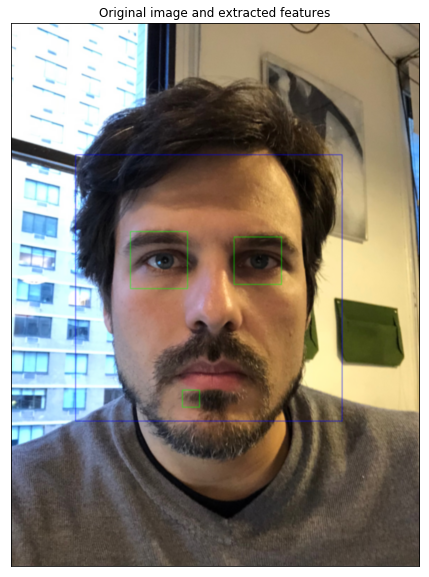

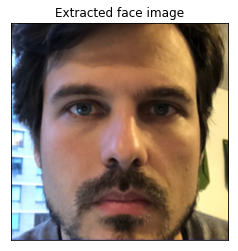

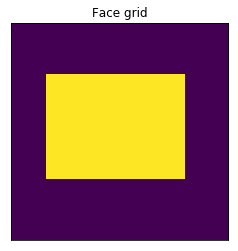

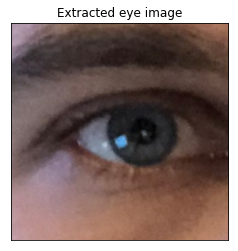

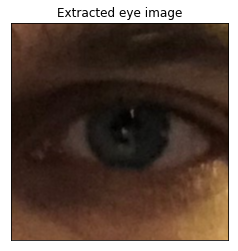

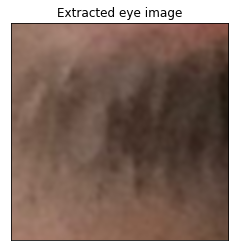

In [7]:
  show_extraction_results(img, faces, face_features)

# Feeding the Input through the Network

Here we will load the model from https://github.com/CSAILVision/GazeCapture.  We will use the 25x snapshot which is trained to handle variations in the images.

In [8]:
import sys
sys.path.append('/usr/bin/caffe')
import caffe

In [9]:
caffe.set_mode_cpu()

model_root = "../GazeCapture/models/"

model_def = model_root + 'itracker_deploy.prototxt'
model_weights = model_root + 'snapshots/itracker25x_iter_92000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [10]:
# set the batch size to 1
def set_batch_size(batch_size):
    net.blobs['image_left'].reshape(batch_size, 3, 224, 224)
    net.blobs['image_right'].reshape(batch_size, 3, 224, 224)
    net.blobs['image_face'].reshape(batch_size, 3, 224, 224)
    net.blobs['facegrid'].reshape(batch_size, 625, 1, 1)   
    
set_batch_size(1)

In [11]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.items():
    print(layer_name + '\t' + str(blob.data.shape))

image_left	(1, 3, 224, 224)
image_right	(1, 3, 224, 224)
image_face	(1, 3, 224, 224)
facegrid	(1, 625, 1, 1)
conv1	(256, 96, 54, 54)
pool1	(256, 96, 27, 27)
norm1	(256, 96, 27, 27)
conv2	(256, 256, 27, 27)
pool2	(256, 256, 13, 13)
norm2	(256, 256, 13, 13)
conv3	(256, 384, 13, 13)
conv4_l	(256, 64, 13, 13)
conv1_r	(256, 96, 54, 54)
pool1_r	(256, 96, 27, 27)
norm1_r	(256, 96, 27, 27)
conv2_r	(256, 256, 27, 27)
pool2_r	(256, 256, 13, 13)
norm2_r	(256, 256, 13, 13)
conv3_r	(256, 384, 13, 13)
conv4_r	(256, 64, 13, 13)
conv1_f	(256, 96, 54, 54)
pool1_f	(256, 96, 27, 27)
norm1_f	(256, 96, 27, 27)
conv2_f	(256, 256, 27, 27)
pool2_f	(256, 256, 13, 13)
norm2_f	(256, 256, 13, 13)
conv3_f	(256, 384, 13, 13)
conv4_f	(256, 64, 13, 13)
fc1_f	(256, 128)
fc2_f	(256, 64)
concat1	(256, 128, 13, 13)
fc1	(256, 128)
flatten	(256, 625)
fg_fc1	(256, 256)
fg_fc2	(256, 128)
concat2	(256, 320)
fc2	(256, 128)
fc3	(256, 2)


In [12]:
# load the mean images
import scipy.io

def get_mean_image(file_name):
    image_mean = np.array(scipy.io.loadmat(model_root + 'mean_images/' + file_name)['image_mean'])
    image_mean = image_mean.reshape(3, 224, 224)
    
    return image_mean.mean(1).mean(1)

mu_face = get_mean_image('mean_face_224.mat')
mu_left_eye = get_mean_image('mean_left_224.mat')
mu_right_eye = get_mean_image('mean_left_224.mat')

In [13]:
# create transformer for the input called 'data'
def create_image_transformer(layer_name, mean_image=None):  
    transformer = caffe.io.Transformer({layer_name: net.blobs[layer_name].data.shape})

    transformer.set_transpose(layer_name, (2,0,1))  # move image channels to outermost dimension
    if mean_image is not None:
        transformer.set_mean(layer_name, mean_image)            # subtract the dataset-mean value in each channel
    return transformer

left_eye_transformer = create_image_transformer('image_left', mu_left_eye)
right_eye_transformer = create_image_transformer('image_right', mu_right_eye)
face_transformer = create_image_transformer('image_face', mu_face)

# face grid transformer just passes through the data
face_grid_transformer = caffe.io.Transformer({'facegrid': net.blobs['facegrid'].data.shape})

In [54]:
import sys
def test_face(face, face_feature):
    face_image, eye_images, face_grid = face_feature
    
    if len(eye_images) < 2:
        return None
    
    start_ms = current_time()
    transformed_left_eye = left_eye_transformer.preprocess('image_left', eye_images[0])
    transformed_right_eye = right_eye_transformer.preprocess('image_right', eye_images[1])
    transformed_face = face_transformer.preprocess('image_face', face_image)
    transformed_face_grid = np.copy(face_grid).reshape(1, 625, 1, 1)
    
    net.blobs['image_left'].data[...] = transformed_left_eye
    net.blobs['image_right'].data[...] = transformed_right_eye
    net.blobs['image_face'].data[...] = transformed_face
    net.blobs['facegrid'].data[...] = transformed_face_grid
    
    output = net.forward()
    net.forward()
    print("Feeding through the network took " + str((current_time() - start_ms) * 1. / 1000) + "s")
    
    return np.copy(output['fc3'][0])
    

def test_faces(faces, face_features):
    outputs = []
    for i, face in enumerate(faces): 
        output = test_face(face, face_features[i])
        
        if output is not None:
            outputs.append(output)
            
    return outputs

In [34]:
outputs = test_faces(faces, face_features)
print("The outputs:", outputs)

Feeding through the network took 0.131s
The outputs: [array([-2.36142087,  1.47598588], dtype=float32)]


## Running on the GPU

In [56]:
# Test performance on CPU
caffe.set_mode_cpu()
outputs = test_faces(faces, face_features)

%timeit test_faces(faces, face_features)

Feeding through the network took 0.543s
Feeding through the network took 0.19s
Feeding through the network took 0.214s
Feeding through the network took 0.214s
Feeding through the network took 0.231s
Feeding through the network took 0.224s
Feeding through the network took 0.197s
Feeding through the network took 0.211s
Feeding through the network took 0.292s
Feeding through the network took 0.269s
Feeding through the network took 0.217s
Feeding through the network took 0.214s
Feeding through the network took 0.195s
Feeding through the network took 0.213s
Feeding through the network took 0.19s
Feeding through the network took 0.211s
Feeding through the network took 0.191s
Feeding through the network took 0.212s
Feeding through the network took 0.189s
Feeding through the network took 0.212s
Feeding through the network took 0.19s
Feeding through the network took 0.213s
Feeding through the network took 0.19s
Feeding through the network took 0.212s
Feeding through the network took 0.19s
Feedi

In [57]:
# run this if cuda enable and gpu has enough memory
caffe.set_mode_gpu()
caffe.set_device(0)  # if we have multiple GPUs, pick the first one

In [58]:
# run once to upload the network to gpu
outputs = test_faces(faces, face_features)

# then timeit
%timeit test_faces(faces, face_features)

Feeding through the network took 0.462s
Feeding through the network took 0.122s
Feeding through the network took 0.118s
Feeding through the network took 0.125s
Feeding through the network took 0.118s
Feeding through the network took 0.12s
Feeding through the network took 0.117s
Feeding through the network took 0.123s
Feeding through the network took 0.118s
Feeding through the network took 0.122s
Feeding through the network took 0.117s
Feeding through the network took 0.12s
Feeding through the network took 0.117s
Feeding through the network took 0.119s
Feeding through the network took 0.117s
Feeding through the network took 0.12s
Feeding through the network took 0.117s
Feeding through the network took 0.12s
Feeding through the network took 0.117s
Feeding through the network took 0.12s
Feeding through the network took 0.116s
Feeding through the network took 0.119s
Feeding through the network took 0.117s
Feeding through the network took 0.121s
Feeding through the network took 0.117s
Feedi

In [21]:
# units in cm
screen_w = 5.58
screen_h = 10.45
screen_aspect = screen_w / screen_h
camera_l = 2.299
camera_t = 0.91
screen_t = 1.719
screen_l = 0.438
phone_w = 6.727
phone_h = 13.844
screen_from_camera = [screen_t - camera_t, screen_l - camera_l]

camera_coords_percentage = [camera_t / phone_h, camera_l / phone_w]

#iphone 8 screen w and screen height from https://www.paintcodeapp.com/news/ultimate-guide-to-iphone-resolutions
screenW = 375
screenH = 667

phone_w_to_screen = phone_w / screen_w
phone_h_to_screen = phone_h / screen_h

In [22]:
def render_gaze(full_image, camera_center, cm_to_px, output):
    xScreen = output[0]
    yScreen = output[1]
    pixelGaze = [round(camera_center[0] - yScreen * cm_to_px), round(camera_center[1] + xScreen * cm_to_px)]
    
    cv2.circle(full_image,(int(pixelGaze[1]), int(pixelGaze[0])), 30, (0, 0, 255), -1)

    
def render_gazes(img, outputs):
    full_image = np.ones((round(img.shape[0] * 2), round(img.shape[1] * 2), 3), dtype=np.uint8)

    full_image_center = [round(full_image.shape[0] * 0.2), round(full_image.shape[1] *.5)]
    camera_center = full_image_center

    cm_to_px = img.shape[0] * 1. / screen_h

    screen_from_camera_px = [round(screen_from_camera[0] * cm_to_px), round(screen_from_camera[1] * cm_to_px)]

    screen_start = [camera_center[0] + screen_from_camera_px[0], camera_center[1] + screen_from_camera_px[1]]
    
    full_image[screen_start[0]:screen_start[0] + img.shape[0], screen_start[1]:screen_start[1] + img.shape[1], :] = img[:, :, :]

    cv2.circle(full_image,(camera_center[1],camera_center[0]), 30, (255, 0, 0), -1)
    
    for output in outputs:
        render_gaze(full_image, camera_center, cm_to_px, output)

    plt.figure(figsize=(10,10))
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")    

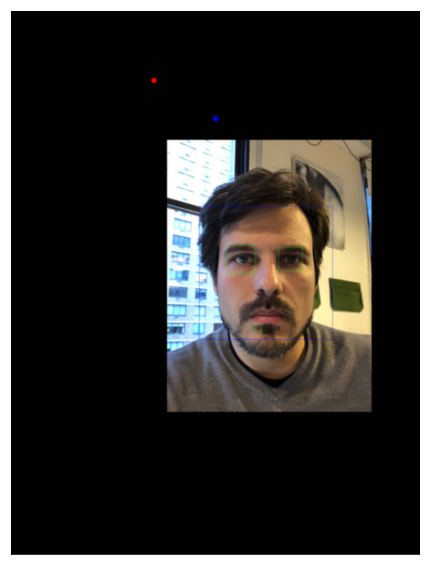

In [23]:
render_gazes(img, outputs)

In [24]:
# lets create a reusable function to extract the features, pass through the network, and render output
def test_and_render(image_path, show_details=False):
    img, faces, face_features = extract_image_features(image_path)
    outputs = test_faces(faces, face_features)

    if show_details:        
        show_extraction_results(img, faces, face_features)

    render_gazes(img, outputs)

Face and eye extraction took:  0.378s
Feeding through the network took 0.097s
Feeding through the network took 0.101s


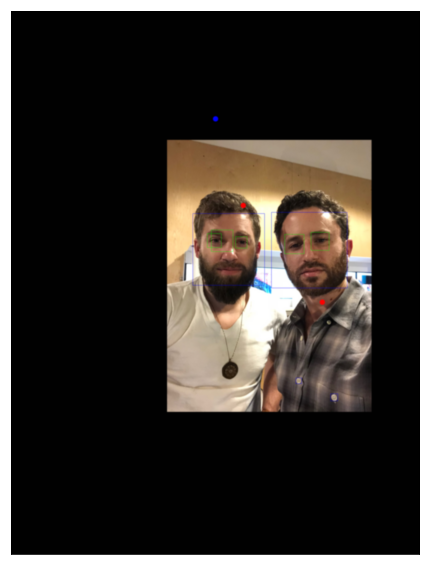

In [25]:
test_and_render('photos/IMG-1066.JPG')

Face and eye extraction took:  0.556s
Feeding through the network took 0.154s


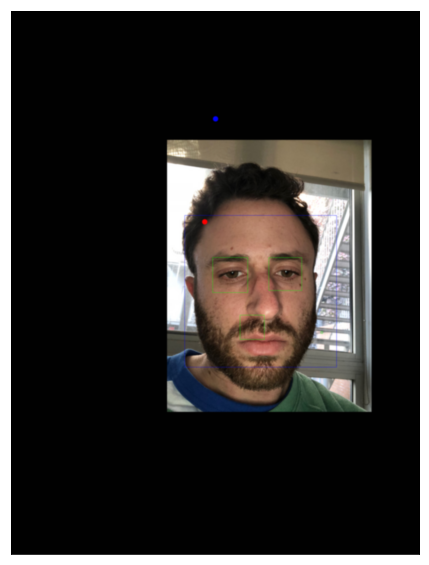

In [26]:
test_and_render('photos/IMG-1036.JPG')

Face and eye extraction took:  0.357s
Feeding through the network took 0.105s


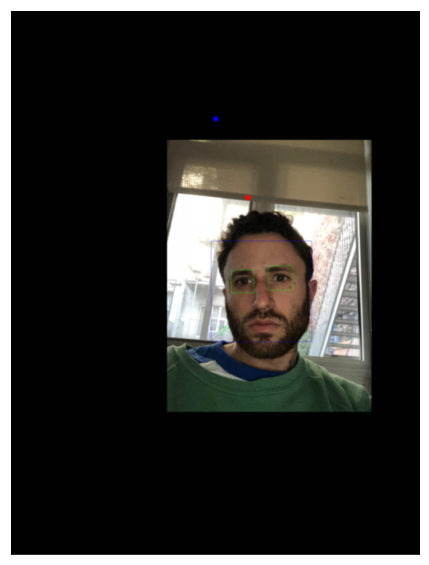

In [27]:
test_and_render('photos/IMG-1037.JPG')

Face and eye extraction took:  0.352s
Feeding through the network took 0.103s


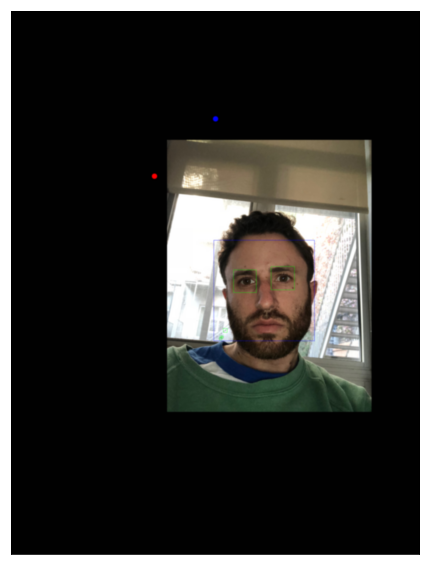

In [28]:
test_and_render('photos/IMG-1038.JPG')

Face and eye extraction took:  0.449s
Feeding through the network took 0.109s


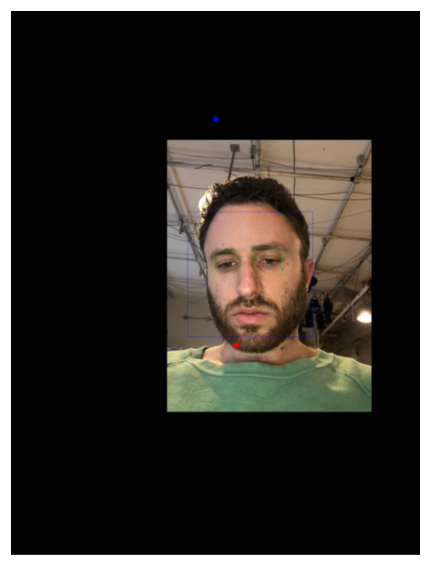

In [29]:
test_and_render('photos/IMG-1044.JPG')

Face and eye extraction took:  0.506s
Feeding through the network took 0.109s


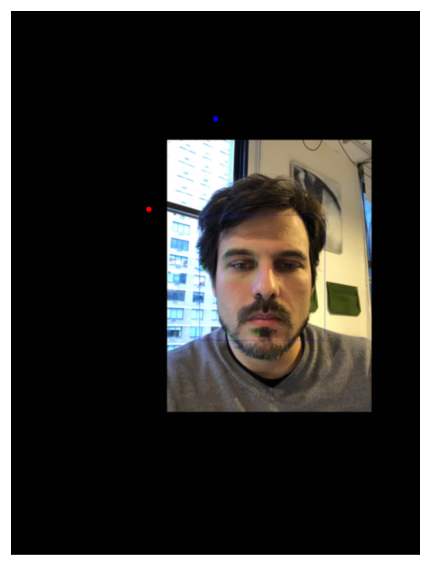

In [30]:
test_and_render('photos/IMG-1052.JPG')

Face and eye extraction took:  0.457s
Feeding through the network took 0.115s


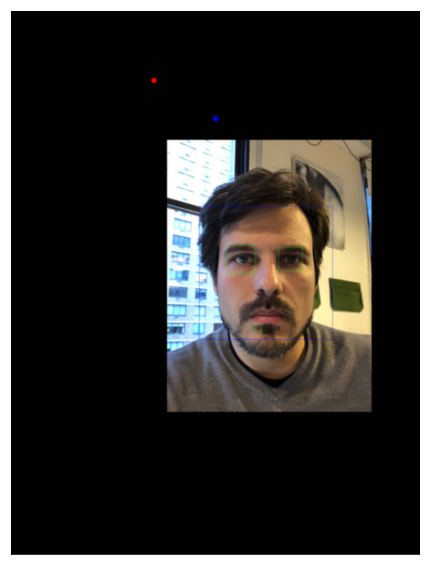

In [31]:
test_and_render('photos/IMG-1053.JPG')

Face and eye extraction took:  0.525s
Feeding through the network took 0.112s


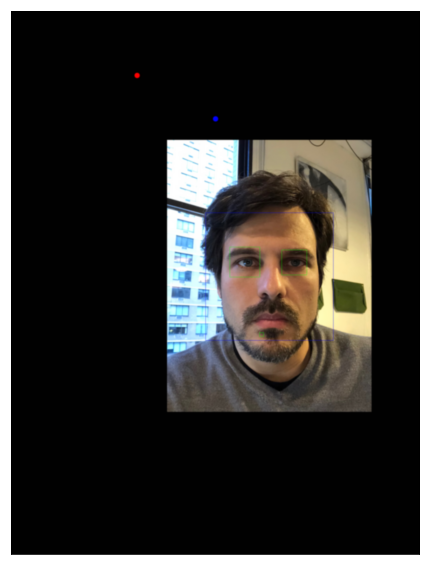

In [32]:
test_and_render('photos/IMG-1054.JPG')

Face and eye extraction took:  0.52s
Feeding through the network took 0.089s


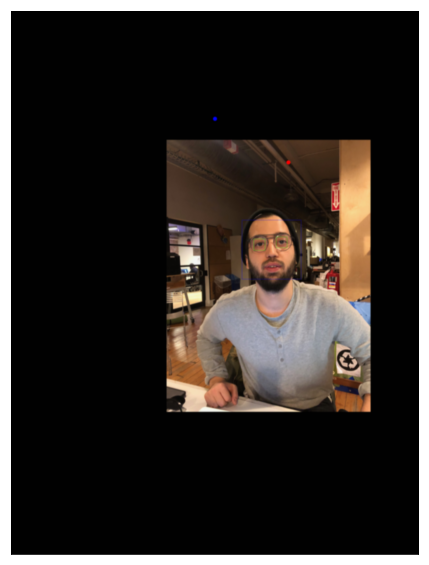

In [33]:
test_and_render('photos/IMG-1055.JPG')